In [9]:
import cv2
import joblib
from skimage.feature import hog
import numpy as np
import imutils
import skimage.measure
from matplotlib import pyplot as plt

In [371]:
def getLetter(nbr):
    if nbr == 0:
        letter = 'a'
    elif nbr == 1:
        letter = 'b'
    elif nbr == 2:
        letter = 'c'
    elif nbr == 3:
        letter = 'd'
    elif nbr == 4:
        letter = 'e'
    elif nbr == 5:
        letter = 'f'
    elif nbr == 6:
        letter = 'h'
    elif nbr == 7:
        letter = 'j'
    elif nbr == 8:
        letter = 'k'
    elif nbr == 9:
        letter = 'l'
    return letter


def preProcessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    imthr = 20
    img[img>imthr] = 255
    img[img<=imthr] = 0
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, (4, 4), iterations = 3)
    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(img,kernel,iterations = 3)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, (3, 3), iterations = 3)
    img = img/255.
    return img

In [204]:

def extractor(sample):
    img = sample.reshape((32, 32))
    fd = list()
    fd += hog(img, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(8, 8)).tolist()
    return fd

def myHog(features, filters):
    list_hog_fd = []
    for feature in features:
        img = feature.reshape((32, 32))
        fd = extractor(feature)
        list_hog_fd.append(fd)


In [261]:
width = 640
height = 480
threshold = 0.6

In [372]:
model = joblib.load("model_trained_wocap_01.pkl")
imgOriginal = cv2.imread("1.jpg")

gray = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2GRAY)
blur = cv2.medianBlur(gray, 5)
thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,8)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,5))
dilate = cv2.dilate(thresh, kernel, iterations=10)

cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnts = cnts[0] if len(cnts) == 2 else cnts[1]

-1

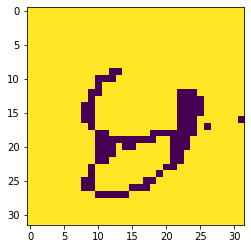

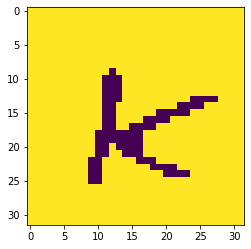

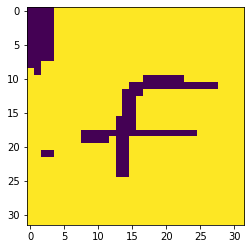

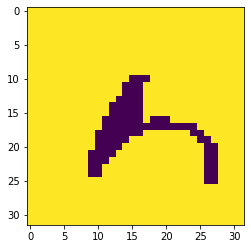

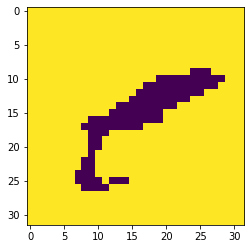

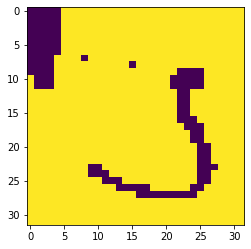

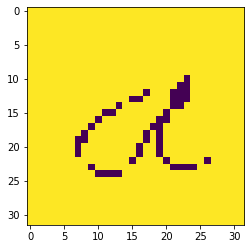

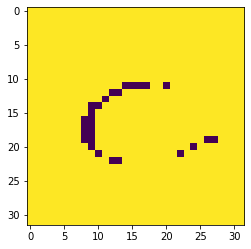

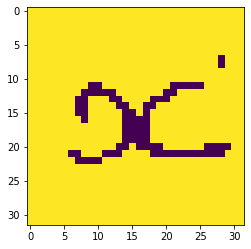

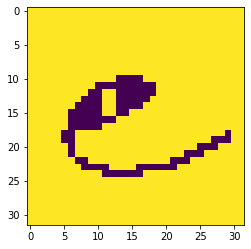

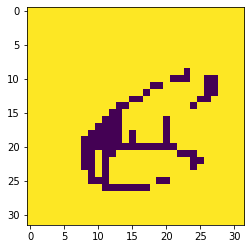

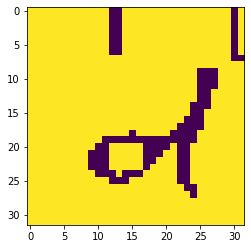

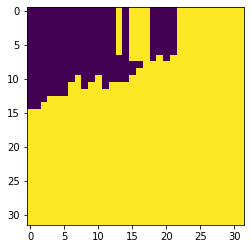

In [373]:
for c in cnts:
    area = cv2.contourArea(c)
    if area > 1000 and area < 100000:
        x,y,w,h = cv2.boundingRect(c)
        if x > 10:
            x -= 20
        if y > 10:
            y + 5
        w += 20
        h += 40
        ROI = imgOriginal[y:y+h, x:x+w]

        img = np.array(ROI)
        
        img = cv2.resize(img, (32, 32))
        img = preProcessing(img)
        img = img.reshape(1, 32, 32, 1)
        roi = cv2.resize(ROI, (32, 32), interpolation=cv2.INTER_AREA)
        roi=preProcessing(roi)
        plt.figure()
        plt.imshow(roi)
        plt.draw()
        # Predict
        roi_hog_fd = extractor(roi)
        classIndex = model.predict(np.array([roi_hog_fd], 'float64'))
        probVal = np.amax(model.predict_proba(np.array([roi_hog_fd], 'float64')))
        if probVal > threshold:
            cv2.rectangle(imgOriginal, (x, y), (x + w, y + h), (0, 0, 255), 3)
            cv2.putText(imgOriginal, getLetter(classIndex) + " " + str(round(probVal, 2)), (x, y+10), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 255), 2)
        else:
            cv2.rectangle(imgOriginal, (x, y), (x + w, y + h), (0, 0, 255), 3)
            cv2.putText(imgOriginal,"-", (x, y), cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 255), 3)
cv2.imwrite('res2.jpg', imgOriginal)
cv2.namedWindow("Resulting Image with Rectangular ROIs", cv2.WINDOW_NORMAL)
cv2.imshow("Resulting Image with Rectangular ROIs", imgOriginal)
cv2.waitKey()